In [1]:
import torch
from torch.utils.data import Dataset

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
# from torch.utils.tensorboard import SummaryWriter
# from tqdm import tqdm
from tqdm.notebook import tqdm

from matplotlib import pyplot as plt

from torch.optim import Optimizer
from torch.optim.lr_scheduler import _LRScheduler

import polars as pl

In [2]:
class CustomDataset(Dataset):
    def __init__(self, embeddings, labels):
        # embeddings: list of numpy arrays or torch tensors
        # labels: list of scalars
        self.X = torch.tensor(embeddings, dtype=torch.float32)
        self.y = torch.tensor(labels, dtype=torch.float32)  # or long, depending on your task

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# BELOW WWAS CHANGED FOR DEBUGGING: CHANGE IT BACK ASAP!!!!

In [3]:
training_dataset = torch.load("../data/2_ready_for_training/mymethod/training.pt")
testing_dataset = torch.load("../data/2_ready_for_training/mymethod/testing.pt")
val_dataset = torch.load("../data/2_ready_for_training/mymethod/val.pt")

/tmp/ipykernel_16896/3403719866.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  training_dataset = torch.load("../data/2_ready_for_training/mymethod/training.pt")
/tmp/i

In [4]:
len(val_dataset), len(testing_dataset), len(training_dataset)

(622, 1952, 10403)

In [5]:
# Define a simple two-layer neural net with dropout and layer norm
class MyMethodNeuralNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MyMethodNeuralNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.1)
        )
        self.layer2 = nn.Sequential(
            nn.Linear(hidden_dim, 1_024),
            nn.LayerNorm(1_024),
            nn.ReLU(),
            nn.Dropout(0.1)
        )
        self.layer3 = nn.Linear(1_024, output_dim)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        return x


input_dim = 4_096# int(testing_dataset.X[0].shape[0])
hidden_dim = 2_048 # int(testing_dataset.X[0].shape[0]/2)

model = MyMethodNeuralNet(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=1)
model = model.to("cuda")

optimizer = optim.AdamW(model.parameters(), lr=1e-4)

num_epochs = 55

# Prepare data loaders
batch_size = 512


In [6]:
# # Define a simple two-layer neural net with dropout and layer norm
# class MyMethodNeuralNet(nn.Module):
#     def __init__(self, input_dim, hidden_dim, output_dim):
#         super(MyMethodNeuralNet, self).__init__()
#         self.layer1 = nn.Sequential(
#             nn.Linear(input_dim, hidden_dim),
#             nn.LayerNorm(hidden_dim),
#             nn.ReLU(),
#             nn.Dropout(0.1)
#         )
#
#         self.layer3 = nn.Linear(hidden_dim, output_dim)
#
#     def forward(self, x):
#         x = self.layer1(x)
#         # x = self.layer2(x)
#         x = self.layer3(x)
#         return x

In [7]:
class FlatLRScheduler(_LRScheduler):
    def __init__(self, optimizer: Optimizer, schedule: list, last_epoch: int = -1):
        """
        Custom Learning Rate Scheduler.

        Args:
            optimizer (Optimizer): Wrapped optimizer.
            schedule (list): List of tuples defining (epoch_range, lr_value).
                             Example: [(9, 1e-3), (8, 1e-4), (8, 1e-5)]
            last_epoch (int): The index of the last epoch. Default is -1.
        """
        self.schedule = []
        total_epochs = 0
        for epochs, lr in schedule:
            total_epochs += epochs
            self.schedule.append((total_epochs, lr))
        super().__init__(optimizer, last_epoch)

    def get_lr(self):
        current_epoch = self.last_epoch + 1
        for end_epoch, lr in self.schedule:
            if current_epoch <= end_epoch:
                return [lr for _ in self.optimizer.param_groups]
        raise ValueError(f"Epoch {current_epoch} is out of range for the provided schedule.")

# Define the schedule: [(9 epochs at 1e-3), (8 epochs at 1e-4), (8 epochs at 1e-5)]
# schedule = [(9, 1e-3), (8, 1e-4), (8, 1e-5)]
# schedule = [(10, 1e-3), (10, 1e-4), (5, 1e-5)]
# schedule = [(15, 1e-3), (16, 1e-4)] # THIS SHOULD BE ONE LONGER THAN NUM_EPOCHS TO AVOID OFF BY ONE ERROR
# schedule = [(5, 1e-3), (15, 1e-4),(16, 1e-5)] # THIS SHOULD BE ONE LONGER THAN NUM_EPOCHS TO AVOID OFF BY ONE ERROR
# schedule = [(35, 1e-4)] # THIS SHOULD BE ONE LONGER THAN NUM_EPOCHS TO AVOID OFF BY ONE ERROR
# schedule = [(1_000, 1e-4)] # THIS SHOULD BE ONE LONGER THAN NUM_EPOCHS TO AVOID OFF BY ONE ERROR
schedule = [(40, 1e-4),(1_000, 1e-5)] # THIS SHOULD BE ONE LONGER THAN NUM_EPOCHS TO AVOID OFF BY ONE ERROR

# Initialize the custom scheduler
scheduler = FlatLRScheduler(optimizer, schedule)


In [8]:
criterion = nn.MSELoss()

In [9]:
train_loader = DataLoader(training_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(testing_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


In [10]:
train_losses = []
test_losses = []
lr_s = []

for epoch_num in range(num_epochs):
    ######################################################################################################################################################################
    test_loss = 0.0
    model.eval()
    with torch.no_grad():
        # for inputs, labels in tqdm(test_loader, desc=f"Testing Epoch {epoch_num}"):
        for inputs, labels in test_loader:
            inputs, labels = inputs.to("cuda"), labels.to("cuda")
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(-1), labels)
            # test_loss += loss.item()
            test_loss += loss.item() * inputs.size(0)  # Multiply batch loss by batch size
        avg_loss = test_loss/len(testing_dataset)
        test_losses.append(avg_loss)
        print(f"TEST LOSS: PRE Epoch-{epoch_num}, we have {avg_loss:.4f}")


    ######################################################################################################################################################################
    model.train()
    train_loss = 0.0

    # for inputs, labels in tqdm(train_loader, desc=f"Training Epoch {epoch_num}"):
    for inputs, labels in train_loader:
        inputs, labels = inputs.to("cuda"), labels.to("cuda")

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        # loss = criterion(outputs, labels) # MY MSITAKE - DO NOT DO THIS
        loss = criterion(outputs.squeeze(-1), labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # train_loss += loss.item()
        train_loss += loss.item() * inputs.size(0)  # Multiply batch loss by batch size
    avg_loss = train_loss/len(training_dataset) # /len(train_dataset) ?? TODO
    train_losses.append(avg_loss)
    # print(f"TRAIN LOSS: On Epoch-{epoch_num}, we have {avg_loss:.4f}")

    scheduler.step()
    current_lr = scheduler.get_last_lr()
    lr_s.append(current_lr)




TEST LOSS: PRE Epoch-0, we have 126.4704
TEST LOSS: PRE Epoch-1, we have 66.4956
TEST LOSS: PRE Epoch-2, we have 51.3875
TEST LOSS: PRE Epoch-3, we have 43.4208
TEST LOSS: PRE Epoch-4, we have 38.0207
TEST LOSS: PRE Epoch-5, we have 33.7133
TEST LOSS: PRE Epoch-6, we have 30.4305
TEST LOSS: PRE Epoch-7, we have 26.8235
TEST LOSS: PRE Epoch-8, we have 24.3691
TEST LOSS: PRE Epoch-9, we have 22.2257
TEST LOSS: PRE Epoch-10, we have 21.8707
TEST LOSS: PRE Epoch-11, we have 19.1002
TEST LOSS: PRE Epoch-12, we have 17.1300
TEST LOSS: PRE Epoch-13, we have 16.8641
TEST LOSS: PRE Epoch-14, we have 14.4125
TEST LOSS: PRE Epoch-15, we have 13.6392
TEST LOSS: PRE Epoch-16, we have 12.5944
TEST LOSS: PRE Epoch-17, we have 11.8239
TEST LOSS: PRE Epoch-18, we have 10.4850
TEST LOSS: PRE Epoch-19, we have 9.9145
TEST LOSS: PRE Epoch-20, we have 9.5676
TEST LOSS: PRE Epoch-21, we have 8.5355
TEST LOSS: PRE Epoch-22, we have 7.8142
TEST LOSS: PRE Epoch-23, we have 7.6985
TEST LOSS: PRE Epoch-24, we ha

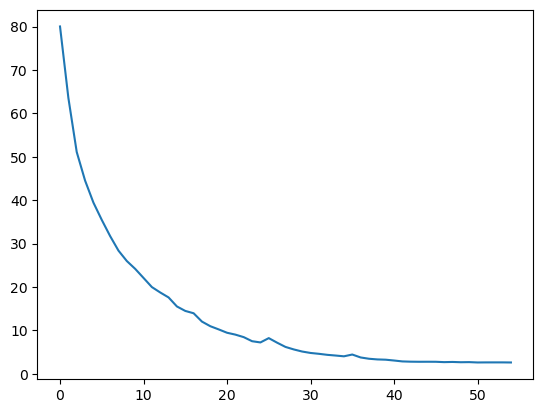

In [11]:
plt.plot(train_losses)

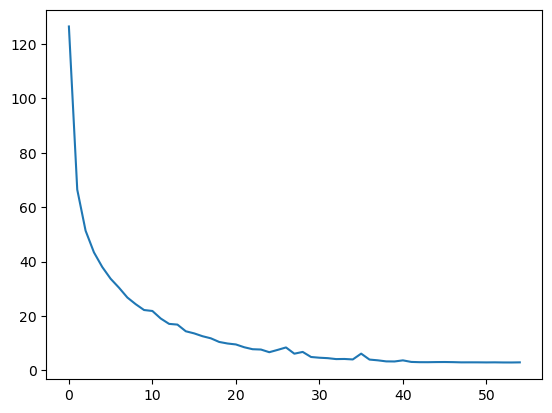

In [12]:
plt.plot(test_losses)

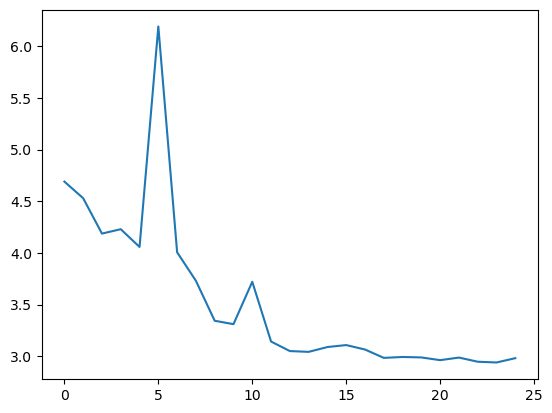

In [13]:
plt.plot(test_losses[30:])

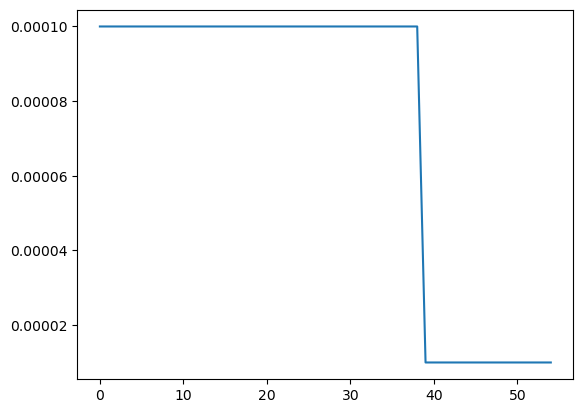

In [14]:
plt.plot(lr_s)

In [15]:
# Assuming val_dataset is a list of (inputs, labels)
inputs_list = []
labels_list = []

for item in val_dataset:
    inputs, labels = item  # Unpack inputs and labels
    inputs_list.append(inputs.cpu().numpy())  # Convert tensors to numpy arrays
    labels_list.append(labels.cpu().numpy())

labels_list_flat = [int(i) for i in labels_list]

# inputs_list_flat = [inp.flatten() for inp in inputs_list]  # Flatten the inputs
# labels_list_flat = [lbl.flatten() for lbl in labels_list]  # Flatten the labels

val_df = pl.DataFrame({
    # "inputs": inputs_list_flat,  # Polars will handle the flat numpy arrays
    "labels": labels_list_flat
})


In [16]:
val_loss = 0.0
model.eval()
predictions = []  # List to store predictions in order

model.eval()
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to("cuda"), labels.to("cuda")
        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs.squeeze(-1), labels)
        val_loss += loss.item() * inputs.size(0)  # Multiply batch loss by batch size

        # Collect predictions
        predictions.extend(outputs.squeeze(-1).cpu().tolist())

# Compute the average loss
avg_loss = val_loss / len(val_dataset)
print(f"ON VAL SET, ACHIEVED {avg_loss:.4f}")


ON VAL SET, ACHIEVED 3.2816


In [17]:
# Use the predictions to create a Polars column
val_df = val_df.with_columns(pl.Series(predictions).alias("mymethod03predictions"))
val_df.write_csv("../outputs/predictions/mymethod03predictions.csv")

In [18]:
torch.save(model.state_dict(), "../models/mymethod/run03.pth")